In [1]:
import sys  
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np

In [2]:
music_before = 30
low_success = 0.25
high_success = 0.75

In [3]:
import src.utils
from src.utils import import_dta, import_tracks_dta, successful_creators_followers,\
gen_active_relations, get_fan_interactions_per_week, calculate_avg_monthly_valence,\
gen_active_relations_prob, get_fan_interactions_per_week_prob, stripplot_prob,\
reaction_probability, follower_list, filter_quantile, sample_creators_music,\
gen_outbound_creators
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
pd.plotting.register_matplotlib_converters()

import src.probability_utils
from src.probability_utils import volume_analysis, valence_analysis
import math
import matplotlib.ticker as plticker
from scipy.interpolate import make_interp_spline, BSpline
import seaborn as sns
from datetime import datetime

In [4]:
path_dir = r"/Users/../Volumes/Raw/"

In [5]:
#we will skip comments for now

#affiliations :follows
#favoritings :likes

tracks = import_tracks_dta(path_dir, "12sample_tracks.dta");
follows_sent = import_dta(path_dir, "12sample_affiliations_sent.dta");
comments_sent = import_dta(path_dir, "12sample_comments_made.dta");
shares_sent = import_dta(path_dir, "12sample_reposts_made.dta");
likes_sent = import_dta(path_dir, "12sample_favoritings_made.dta");
messages_sent = import_dta(path_dir, "12sample_messages_sent.dta");

user_info = import_dta(path_dir, "12sample_user_infos.dta");
user_info_2 = import_dta(path_dir, "12sample_1st_deg_user_infos.dta");
user_info = pd.concat([user_info, user_info_2]);
user_info.drop_duplicates(subset='user_id', keep='first', inplace=True, ignore_index=False);


########
follows_received = import_dta(path_dir, "12sample_affiliations_received.dta");
comments_received = import_dta(path_dir, "12sample_comments_received.dta");
shares_received = import_dta(path_dir, "12sample_reposts_received.dta");
likes_received = import_dta(path_dir, "12sample_favoritings_received.dta");
messages_received = import_dta(path_dir, "12sample_messages_received.dta");

########
follows = import_dta(path_dir, "12sample_affiliations.dta");
comments = import_dta(path_dir, "12sample_comments.dta");
shares = import_dta(path_dir, "12sample_reposts.dta");
likes = import_dta(path_dir, "12sample_favoritings.dta");
messages = import_dta(path_dir, "12sample_messages.dta");

tracks_first_month = sample_creators_music(tracks, music_before)
mask = tracks_first_month.track_available == 1
tracks_first_month = tracks_first_month[mask]

mask = follows_received.contact_id.isin(tracks_first_month.user_id)
follows_received_30 = follows_received[mask]
followers_per_creator_60 = successful_creators_followers(follows_received_30, 60, tracks_first_month)
followers_per_creator_60_static = successful_creators_followers(follows_received_30, 60, tracks_first_month, always_same_batches = True, 
                                                        perc1 = low_success, perc2 = high_success)

%%%%%%%%%% 12sample_tracks.dta %%%%%%%%%%
(56262, 7)
%%%%%%%%%% 12sample_affiliations_sent.dta %%%%%%%%%%
(800913, 3)
%%%%%%%%%% 12sample_comments_made.dta %%%%%%%%%%
(29258, 4)
%%%%%%%%%% 12sample_reposts_made.dta %%%%%%%%%%
(179329, 4)
%%%%%%%%%% 12sample_favoritings_made.dta %%%%%%%%%%
(527701, 4)
%%%%%%%%%% 12sample_messages_sent.dta %%%%%%%%%%
(11091, 3)
%%%%%%%%%% 12sample_user_infos.dta %%%%%%%%%%
(35000, 3)
%%%%%%%%%% 12sample_1st_deg_user_infos.dta %%%%%%%%%%
(670746, 3)
%%%%%%%%%% 12sample_affiliations_received.dta %%%%%%%%%%
(432503, 3)
%%%%%%%%%% 12sample_comments_received.dta %%%%%%%%%%
(21386, 4)
%%%%%%%%%% 12sample_reposts_received.dta %%%%%%%%%%
(83013, 4)
%%%%%%%%%% 12sample_favoritings_received.dta %%%%%%%%%%
(286903, 4)
%%%%%%%%%% 12sample_messages_received.dta %%%%%%%%%%
(17364, 3)
%%%%%%%%%% 12sample_affiliations.dta %%%%%%%%%%
(1233416, 3)
%%%%%%%%%% 12sample_comments.dta %%%%%%%%%%
(50644, 4)
%%%%%%%%%% 12sample_reposts.dta %%%%%%%%%%
(262342, 4)
%%%%%%%%%% 12sam

In [6]:
actions_sent = gen_outbound_creators(follows_sent, shares_sent, likes_sent, comments_sent, tracks,
                                     messages_sent = messages_sent)

In [7]:
actions_sent.user_id.nunique()

4615

In [8]:
mask = actions_sent.user_id.isin(tracks_first_month.user_id) 
actions_sent = actions_sent[mask]
actions_sent_filtered = actions_sent.merge(followers_per_creator_60_static, left_on = 'user_id', right_on = 'user_id', how = "inner")
#actions_sent = actions_sent.merge(followers_per_creator_60, left_on = 'user_id', right_on = 'user_id', how = "inner")
#actions_sent_filtered = filter_quantile(actions_sent, low_success, high_success)

In [9]:
actions_sent_filtered.groupby('high_low').user_id.nunique()

high_low
high    644
low     446
Name: user_id, dtype: int64

## followers only

In [10]:
def process_date(date):
    year = date[0:4]
    week = date[6:]
    day = "1"
    date = "{}-{}-1".format(year, week)
    dt = datetime.strptime(date, "%Y-%W-%w")
    return dt

In [11]:
def split_dfs(df):
    mask = df.high_low == 'high'
    data1 = df[mask]

    data1 = data1.groupby(['outbound_activity', 'week_yr'], as_index = False).size()
    data1_sum = data1.groupby(['week_yr'], as_index = False).agg(total = ('size', 'sum'))
    data1 = data1.merge(data1_sum, right_on = 'week_yr', left_on = 'week_yr')
    data1['pct'] = round((data1['size']/data1.total)*100,1)
    data1 = data1.fillna(0)

    mask = df.high_low == 'low'
    data2 = df[mask]

    data2 = data2.groupby(['outbound_activity', 'week_yr'], as_index = False).size()
    data2_sum = data2.groupby(['week_yr'], as_index = False).agg(total = ('size', 'sum'))
    data2 = data2.merge(data2_sum, right_on = 'week_yr', left_on = 'week_yr')
    data2['pct'] = round((data2['size']/data2.total)*100,1)
    
    data1_wide = data1.pivot("week_yr", "outbound_activity", "pct")
    data1_wide = data1_wide.fillna(0)
    
    data2_wide = data2.pivot("week_yr", "outbound_activity", "pct")
    data2_wide = data2_wide.fillna(0)
    
    return data1_wide, data2_wide, data1, data2, data1_sum, data2_sum

In [12]:
def plot(dataset1, dataset2, dataset1_sum, dataset2_sum, title, number, footnote):
    sns.set(rc={'figure.figsize':(15,15)})
    sns.set_style("white")
    fig, axes = plt.subplots(2,1)

    sns.lineplot(data=dataset1, palette="viridis", dashes = True, ax=axes[0])\
    .set(title='Figure {}: {} - Outbound Activities - Successful Creators'.format(number, title), xlabel='Week',
       ylabel='Percentage')

    ax2 = axes[0].twinx()
    sns.lineplot(data=dataset1_sum.total, color="black", ax=ax2)

    sns.lineplot(data=dataset2, palette="viridis", dashes = True, ax=axes[1])\
    .set(title='Figure {}: {} - Outbound Activities - Unsuccessful Creators'.format(number+1, title), xlabel='Week',
       ylabel='Percentage')

    ax2 = axes[1].twinx()
    sns.lineplot(data=dataset2_sum.total, color="black", ax=ax2)
    
    plt.annotate(footnote, (0,0), (0, -55), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=14);

    loc = plticker.MultipleLocator(base=10.0) # this locator puts ticks at regular intervals
    axes[0].xaxis.set_major_locator(loc)
    axes[1].xaxis.set_major_locator(loc)

In [13]:
def plot2(dataset1_sum, dataset2_sum, title, number, footnote):
    sns.set(rc={'figure.figsize':(15,15)})
    sns.set_style("white")
    
    dataset1_sum['week_yr_date'] = dataset1_sum.week_yr.apply(lambda x: process_date(x))
    dataset2_sum['week_yr_date'] = dataset2_sum.week_yr.apply(lambda x: process_date(x))
    
    fig, axes = plt.subplots(2,1)
    
    sns.lineplot(data=dataset1_sum, y=dataset1_sum.total, x = dataset1_sum.week_yr_date, color="black", ax=axes[0])\
    .set(title = 'Figure {}: Number os activities per week - Successfull Creators - {}'.format(number ,title), xlabel = 'Week', ylabel = 'Number of activities')
    
    sns.lineplot(data=dataset2_sum, y=dataset2_sum.total, x = dataset2_sum.week_yr_date, color="black", ax=axes[1])\
    .set(title = 'Figure {}: Number os activities per week - Unsuccessfull Creators- {}'.format(number+ 1,title), xlabel = 'Week', ylabel = 'Number of activities')

    plt.annotate(footnote
             , (0,0), (0, -55), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=14);
    
    loc = plticker.MultipleLocator(base=75.0) # this locator puts ticks at regular intervals
    fig.autofmt_xdate()
    axes[0].set(xlim=(datetime(2013, 3, 1, 0, 0, 0), datetime(2015, 7, 1, 0, 0, 0)))
    axes[1].set(xlim=(datetime(2013, 3, 1, 0, 0, 0), datetime(2015, 7, 1, 0, 0, 0)))
    #axes[0].xaxis.set_major_locator(loc)
    #axes[1].xaxis.set_major_locator(loc)

In [14]:
print('Obtaining fanbase...')
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follower_list(follows_received)
actions_sent_filtered = actions_sent_filtered.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

mask = (actions_sent_filtered.date_sent > actions_sent_filtered.follower_since)
actions_sent_filtered_fanbase =  actions_sent_filtered[mask]
actions_sent_filtered_fanbase['week_yr_date'] = actions_sent_filtered_fanbase.week_yr.apply(lambda x: process_date(x))

mask = (actions_sent_filtered.date_sent < actions_sent_filtered.follower_since)  | (actions_sent_filtered.follower_since.isnull())
actions_sent_filtered_non_followers =  actions_sent_filtered[mask]
actions_sent_filtered_non_followers['week_yr_date'] = actions_sent_filtered_non_followers.week_yr.apply(lambda x: process_date(x))

Obtaining fanbase...


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_54856/1883264444.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_fanbase['week_yr_date'] = actions_sent_filtered_fanbase.week_yr.apply(lambda x: process_date(x))
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_54856/1883264444.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_non_followers['week_yr_date'] = actions_sent_filtered_non_followers.week_yr.apply(lambda x: process_date(x))


In [33]:
actions_sent_filtered.shape

(126129, 10)

In [34]:
actions_sent_filtered_fanbase.shape

(18993, 11)

In [35]:
actions_sent_filtered.groupby('high_low').user_id.nunique()

high_low
high    644
low     446
Name: user_id, dtype: int64

In [36]:
actions_sent_filtered_fanbase.groupby('high_low').user_id.nunique()

high_low
high    542
low      19
Name: user_id, dtype: int64

In [37]:
actions_sent_filtered_non_followers.groupby('high_low').user_id.nunique()

high_low
high    637
low     442
Name: user_id, dtype: int64

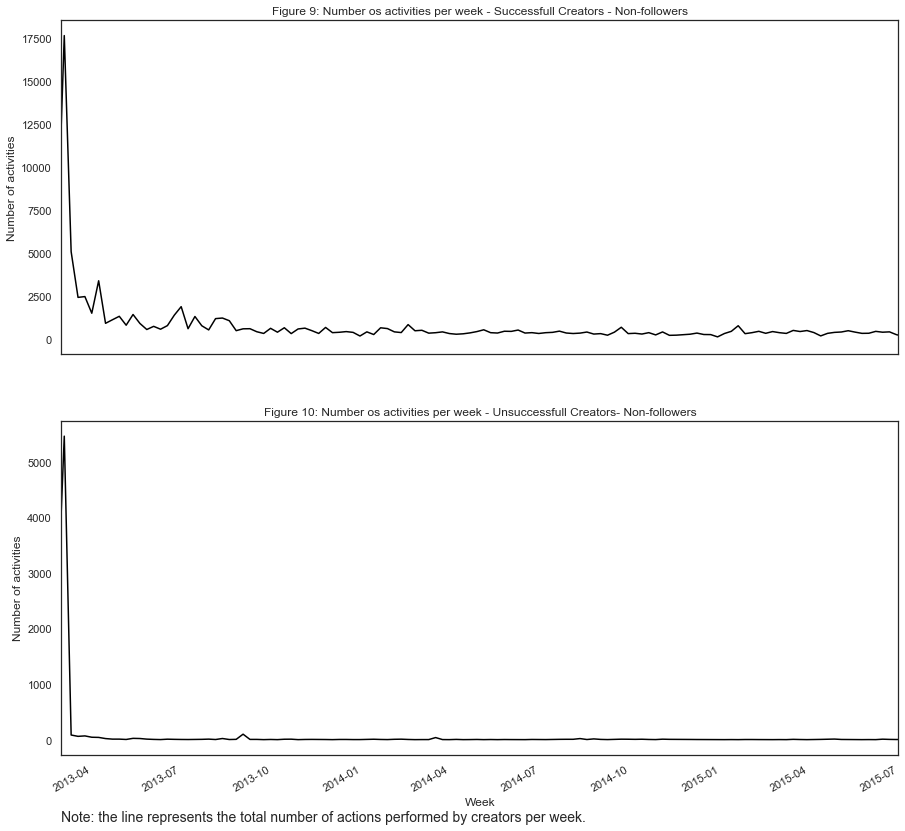

In [31]:
data1_wide, data2_wide, data1, data2, data1_sum, data2_sum = split_dfs(actions_sent_filtered_non_followers)
plot2(data1_sum, data2_sum, "Non-followers", 9, '''Note: the line represents the total number of actions performed by creators per week.''')

In [23]:
# data1_wide.to_csv("outboundact_highsuccess_nofollowers.csv")
# data2_wide.to_csv("outboundact_lowsuccess_nofollowers.csv")
# data1_sum.to_csv("totalact_highsuccess_nofollowers.csv")
# data2_sum.to_csv("totalact_lowsuccess_nofollowers.csv")

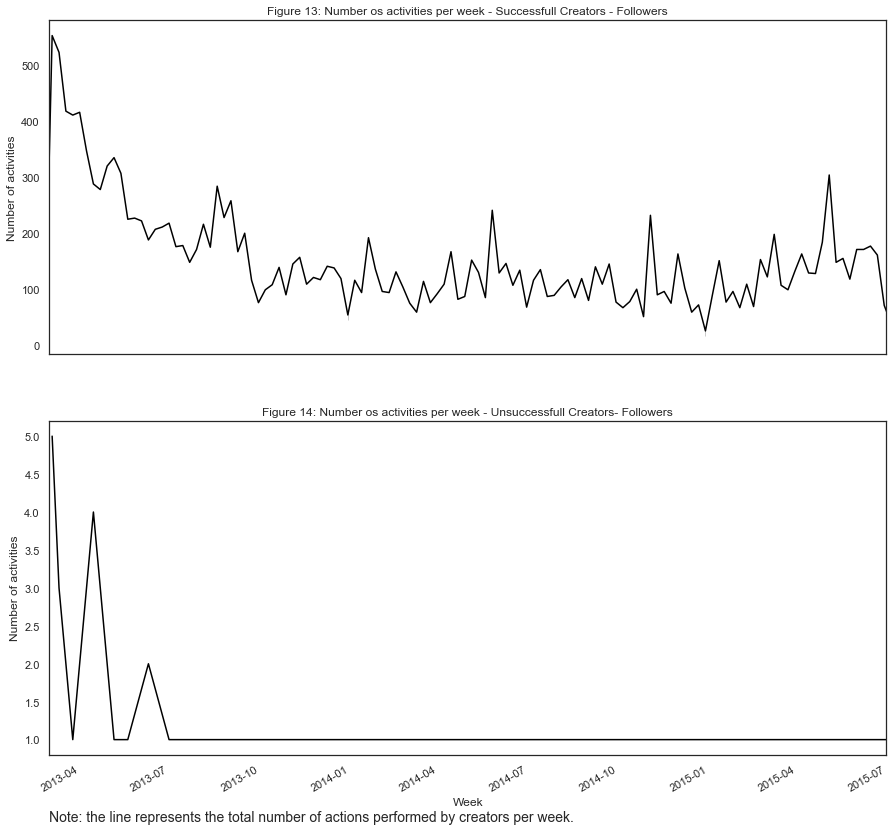

In [24]:
data1_wide, data2_wide, data1, data2, data1_sum, data2_sum = split_dfs(actions_sent_filtered_fanbase)
plot2(data1_sum, data2_sum, 'Followers',13, '''Note: the line represents the total number of actions performed by creators per week.''')

In [25]:
data1_wide.to_csv("outboundact_highsuccess_followers.csv")
data2_wide.to_csv("outboundact_lowsuccess_followers.csv")
data1_sum.to_csv("totalact_highsuccess_followers.csv")
data2_sum.to_csv("totalact_lowsuccess_followers.csv")

Filter out who never sent any action?

In [26]:
def action_plot(df, title, number, footnote):
    sns.set(rc={'figure.figsize':(15,15)})
    sns.set_style("white")
    fig, axes = plt.subplots(2,1)

    mask = df.high_low == 'high'
    sns.kdeplot(data=df[mask],
            x="week_yr_date",
            hue="outbound_activity",
            hue_order= ['follow', 'share', 'like', 'comment', 'message'],
            multiple="fill",
            bw_adjust = 1,
            ax = axes[0])\
    .set(title='Figure {}: {} - Outbound Activities - Successful Creators'.format(number, title), xlabel='Week',
       ylabel='Percentage');

    axes[0].set(xlim=(datetime(2013, 3, 1, 0, 0, 0), datetime(2015, 7, 1, 0, 0, 0)))

    mask = df.high_low == 'low'
    sns.kdeplot(data=df[mask],
            x="week_yr_date",
            hue="outbound_activity",
            hue_order= ['follow', 'share', 'like', 'comment', 'message'], 
            multiple="fill",
            bw_adjust = 1,
            ax = axes[1])\
    .set(title='Figure {}: {} - Outbound Activities - Unuccessful Creators'.format(number + 1, title), xlabel='Week',
       ylabel='Percentage');
    plt.annotate(footnote, (0,0), (0, -55), xycoords='axes fraction', textcoords='offset points', va='top',fontsize=14);

    axes[1].set(xlim=(datetime(2013, 3, 1, 0, 0, 0), datetime(2015, 7, 1, 0, 0, 0)))

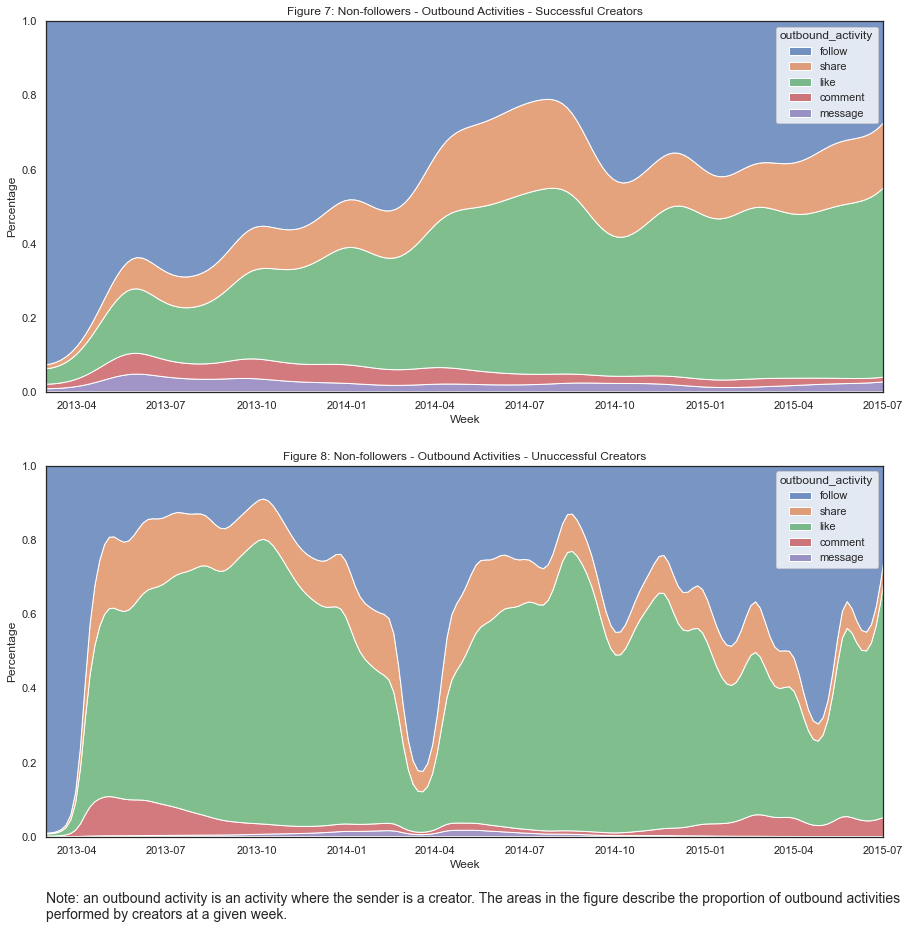

In [27]:
action_plot(actions_sent_filtered_non_followers, "Non-followers", 7, 
'''Note: an outbound activity is an activity where the sender is a creator. The areas in the figure describe the proportion of outbound activities 
performed by creators at a given week.''')

In [28]:
actions_sent_filtered_non_followers\
.to_excel("/Users/caiorego/Downloads/Median splits 50% percentil Figures and Tables - data.xlsx", sheet_name = "Fig 7")

/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/venv/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


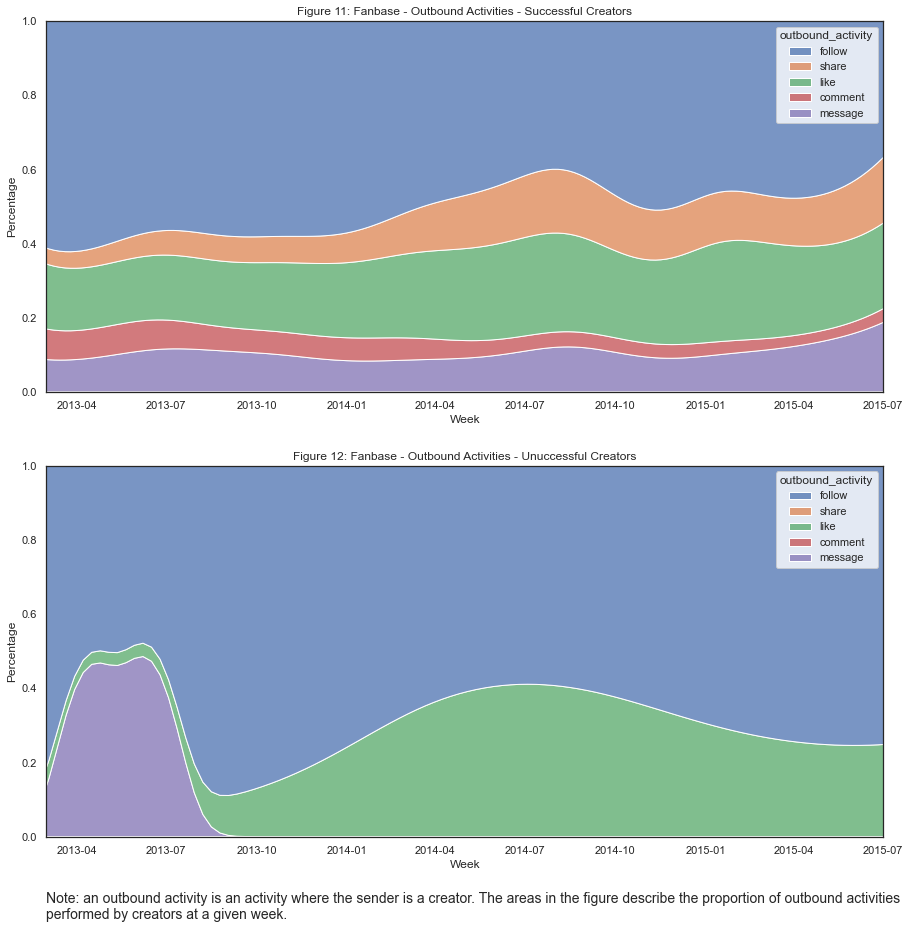

In [29]:
action_plot(actions_sent_filtered_fanbase, "Fanbase", 11,
'''Note: an outbound activity is an activity where the sender is a creator. The areas in the figure describe the proportion of outbound activities
performed by creators at a given week.''')

Table tentative

In [30]:
actions_sent_filtered_fanbase\
.to_excel("/Users/caiorego/Downloads/Median splits 50% percentil Figures and Tables - data.xlsx", sheet_name = "Fig 7")

In [1]:
from scipy.stats import pearsonr

In [4]:
pearsonr([5,7,3], [4,6,5])

(0.4999999999999999, 0.6666666666666669)